In [17]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import PIL.Image as Image

## Goal:

Convolutional neural network
We tested above different models with the set of high-level features extracted from a pretrained neural network. However, can you get similar results by creating a ConvNet from scratch and using the pixel values from the original images to train the model?

What accuracy can we achieve?
Can we get good results? - If not, why?

### load the npz file and create the array to be then used for model training and testing

In [18]:
with np.load('images_data.npz', allow_pickle=True) as npz_file:
    df = pd.DataFrame(npz_file['values'], columns= npz_file['columns'])
    
df_train = df[df['imageSet'] == 'train']
df_valid = df[df['imageSet'] == 'valid']
df_test = df[df['imageSet'] == 'test']

### transform the categories into numerical values for NN output

In [19]:
def cat2num(x):
    if x == 'bike':
        return 0
    if x=='car':
        return 1
    if x =='motorcycle':
        return 2
    if x == 'other':
        return 3
    if x =='truck':
        return 4
    if x =='van':
        return 5
df_train['category_num'] = df_train['category'].apply(cat2num)
df_valid['category_num'] = df_valid['category'].apply(cat2num)
df_test['category_num'] = df_test['category'].apply(cat2num)
y_tr = df_train.category_num.values
y_va = df_valid.category_num.values
y_te = df_test.category_num.values

C:\Users\lmbhoc2\AppData\Local\Continuum\anaconda3\envs\exts-ml\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\lmbhoc2\AppData\Local\Continuum\anaconda3\envs\exts-ml\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\lmbhoc2\AppData\Local\Continuum\anaconda3\envs\exts-ml\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

### Create the input data from raw image for the Neural network:
- open each image with PIL => get an array (256x256x3)
- convert data to float and scale between -0.5 and 0.5

In [20]:
features = []
for i in range(df_train.shape[0]):
    pillow_img = Image.open(df_train['imageFileName'].iloc[i])
    img = np.array(pillow_img)
    features.append(img)
X_tr = np.array(features).astype(np.float32)
X_tr = (X_tr - 128) / 255

features = []
for i in range(df_test.shape[0]):
    pillow_img = Image.open(df_test['imageFileName'].iloc[i])
    img = np.array(pillow_img)
    features.append(img)
X_te = np.array(features).astype(np.float32)
X_te = (X_te - 128) / 255

features = []
for i in range(df_valid.shape[0]):
    pillow_img = Image.open(df_valid['imageFileName'].iloc[i])
    img = np.array(pillow_img)
    features.append(img)
X_va = np.array(features).astype(np.float32)
X_va = (X_va - 128) / 255

print("shape X_tr : " + str(X_tr.shape) + " - shape y_tr : " + str(y_tr.shape))
print("shape X_va:" + str(X_va.shape) + " - shape y_va : " + str(y_va.shape))
print("shape X_te " + str(X_te.shape) + " - shape y_te : " + str(y_te.shape))

shape X_tr : (280, 256, 256, 3) - shape y_tr : (280,)
shape X_va:(139, 256, 256, 3) - shape y_va : (139,)
shape X_te (50, 256, 256, 3) - shape y_te : (50,)


### create a batch generator function

In [21]:
def get_batches(X, y, batch_size):
    shuffled_idx = np.arange(len(y))
    np.random.shuffle(shuffled_idx)
    
    for i in range(0, len(y), batch_size):
        batch_idx = shuffled_idx[i:i+batch_size]
        yield X[batch_idx], y[batch_idx]

In [22]:
import tensorflow as tf

# Create new graph
graph = tf.Graph()

with graph.as_default():
    # Placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 256, 256, 3])
    y = tf.placeholder(dtype=tf.int32, shape=[None])
    print('Input:', X.shape)
    
    # Convolutional layer (64 filters, 10x10 kernel, stride: 4)
    conv1 = tf.layers.conv2d(
        X, 64, (10, 10), (4, 4), 'SAME', # "same" padding
        activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.truncated_normal_initializer(stddev=0.01, seed=0),
        name='conv1'
    )
    print('Convolutional layer:', conv1.shape)
    
    # Maxpool layer (4x4, stride: 4, "same" padding)
    pool1 = tf.layers.max_pooling2d(conv1, (4, 4), (4, 4), 'SAME')
    print('Maxpool:', pool1.shape)
    
    # Convolutional layer (64 filters, 3x3, stride: 1)
    conv2 = tf.layers.conv2d(
        pool1, 64, (3, 3), (1, 1), 'SAME', # "same" padding
        activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.truncated_normal_initializer(stddev=0.01, seed=0),
        name='conv2'
    )
    print('Convolutional layer:', conv2.shape)
    
    # Maxpool layer (4x4, stride: 4, "same" padding)
    pool2 = tf.layers.max_pooling2d(conv2, (4, 4), (4, 4), 'SAME')
    print('Maxpool:', pool2.shape)
    
    # Flatten output
    flat_output = tf.contrib.layers.flatten(pool2)
    print('Flatten:', flat_output.shape)
    
    # Dropout
    training = tf.placeholder(dtype=tf.bool)
    flat_output = tf.layers.dropout(flat_output, rate=0.5, seed=0, training=training)
    print('Dropout:', flat_output.shape)
    
    # Fully connected layer
    fc1 = tf.layers.dense(
        flat_output, 256, # 256 hidden units
        activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
        bias_initializer=tf.zeros_initializer()
    )
    print('Fully-connected layer:', fc1.shape)
    
    # Output layer
    logits = tf.layers.dense(
        fc1, 6, 
        activation=None, # No activation function
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
        bias_initializer=tf.zeros_initializer()
    )
    print('Output layer:', logits.shape)
    
    # Kernel of the 1st conv. layer
    with tf.variable_scope('conv1', reuse=True):
        conv_kernels = tf.get_variable('kernel')
    
    # Mean cross-entropy
    mean_ce = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=y, logits=logits))
    
    # Adam optimizer
    lr = tf.placeholder(dtype=tf.float32)
    gd = tf.train.AdamOptimizer(learning_rate=lr)

    # Minimize cross-entropy
    train_op = gd.minimize(mean_ce)
    
    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))

Input: (?, 256, 256, 3)
Convolutional layer: (?, 64, 64, 64)
Maxpool: (?, 16, 16, 64)
Convolutional layer: (?, 16, 16, 64)
Maxpool: (?, 4, 4, 64)
Flatten: (?, 1024)
Dropout: (?, 1024)
Fully-connected layer: (?, 256)
Output layer: (?, 6)


In [23]:
# Validation accuracy
valid_acc_values = []

with tf.Session(graph=graph) as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    # Set seed
    np.random.seed(0)
    
    # Train several epochs
    for epoch in range(15):
        # Accuracy values (train) after each batch
        batch_acc = []
        
        for X_batch, y_batch in get_batches(X_tr, y_tr, 30):
            # Run training and evaluate accuracy
            _, acc_value = sess.run([train_op, accuracy], feed_dict={
                X: X_batch,
                y: y_batch,
                lr: 0.001, # Learning rate
                training: True
            })
            
            # Save accuracy (current batch)
            batch_acc.append(acc_value)

        # Evaluate validation accuracy
        valid_acc = sess.run(accuracy, feed_dict={
            X: X_va,
            y: y_va,
            training: False
        })
        valid_acc_values.append(valid_acc)
        
        # Print progress
        print('Epoch {} - valid: {:.3f} train: {:.3f} (mean)'.format(
            epoch+1, valid_acc, np.mean(batch_acc)
        ))
        
    # Get 1st conv. layer kernels
    kernels = conv_kernels.eval()
    
    # Evaluate test accuracy
    test_acc = sess.run(accuracy, feed_dict={
        X: X_te,
        y: y_te,
            training: False
    })
    print('Test accuracy: {:.3f}'.format(test_acc))

Epoch 1 - valid: 0.345 train: 0.223 (mean)
Epoch 2 - valid: 0.266 train: 0.290 (mean)
Epoch 3 - valid: 0.273 train: 0.353 (mean)
Epoch 4 - valid: 0.288 train: 0.320 (mean)
Epoch 5 - valid: 0.331 train: 0.350 (mean)
Epoch 6 - valid: 0.345 train: 0.397 (mean)
Epoch 7 - valid: 0.403 train: 0.447 (mean)
Epoch 8 - valid: 0.353 train: 0.443 (mean)
Epoch 9 - valid: 0.396 train: 0.480 (mean)
Epoch 10 - valid: 0.453 train: 0.533 (mean)
Epoch 11 - valid: 0.475 train: 0.503 (mean)
Epoch 12 - valid: 0.540 train: 0.580 (mean)
Epoch 13 - valid: 0.518 train: 0.627 (mean)
Epoch 14 - valid: 0.496 train: 0.637 (mean)
Epoch 15 - valid: 0.518 train: 0.677 (mean)
Test accuracy: 0.680


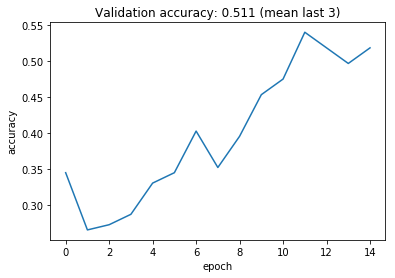

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot accuracy values
plt.plot(valid_acc_values)
plt.title('Validation accuracy: {:.3f} (mean last 3)'.format(
    np.mean(valid_acc_values[-3:]) # last three values
))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

- test accuracy is 0.68
- The CNN is not performing that well as the amount of pictures to learn is quite low , 280 images for 6 classes. Moreover only 2 convolution layers were applied and one hidden layer on the connected layer which I guess is less than the CNN Mobilenet V2 to obtain the 1280 features.